<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cells below before starting this notebook!
</div>

In [ ]:
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
alg_seq_check(answer) = answer_checker(answer,"c")
alg_seq_loops_check(answer) = answer_checker(answer,"d")
alg_1_deps_check(answer) = answer_checker(answer,"b")
alg_1_complex_check(answer) = answer_checker(answer,"d")
alg_1_time_check(answer) = answer_checker(answer,"a")
alg_1_v2_complex_check(answer) = answer_checker(answer,"c")
alg_1_v2_time_check(answer) = answer_checker(answer,"a")

# Distributed matrix-matrix multiplication

## Problem Statement

Let us consider the (dense) matrix-matrix product `C=A*B`:

 <div>
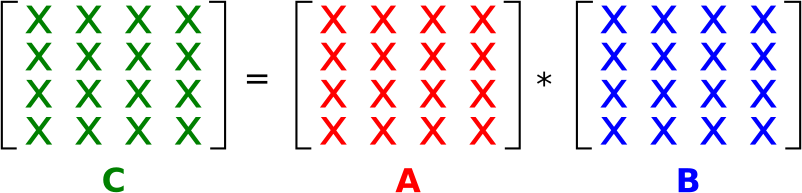
</div>


Our goal is to compute the product in parallel using more than one process (distributed implementation).

We assume that:

- All matrices `A`,`B`, and `C` are initially stored in the master process
- The result will be overwritten in `C`

 <div>
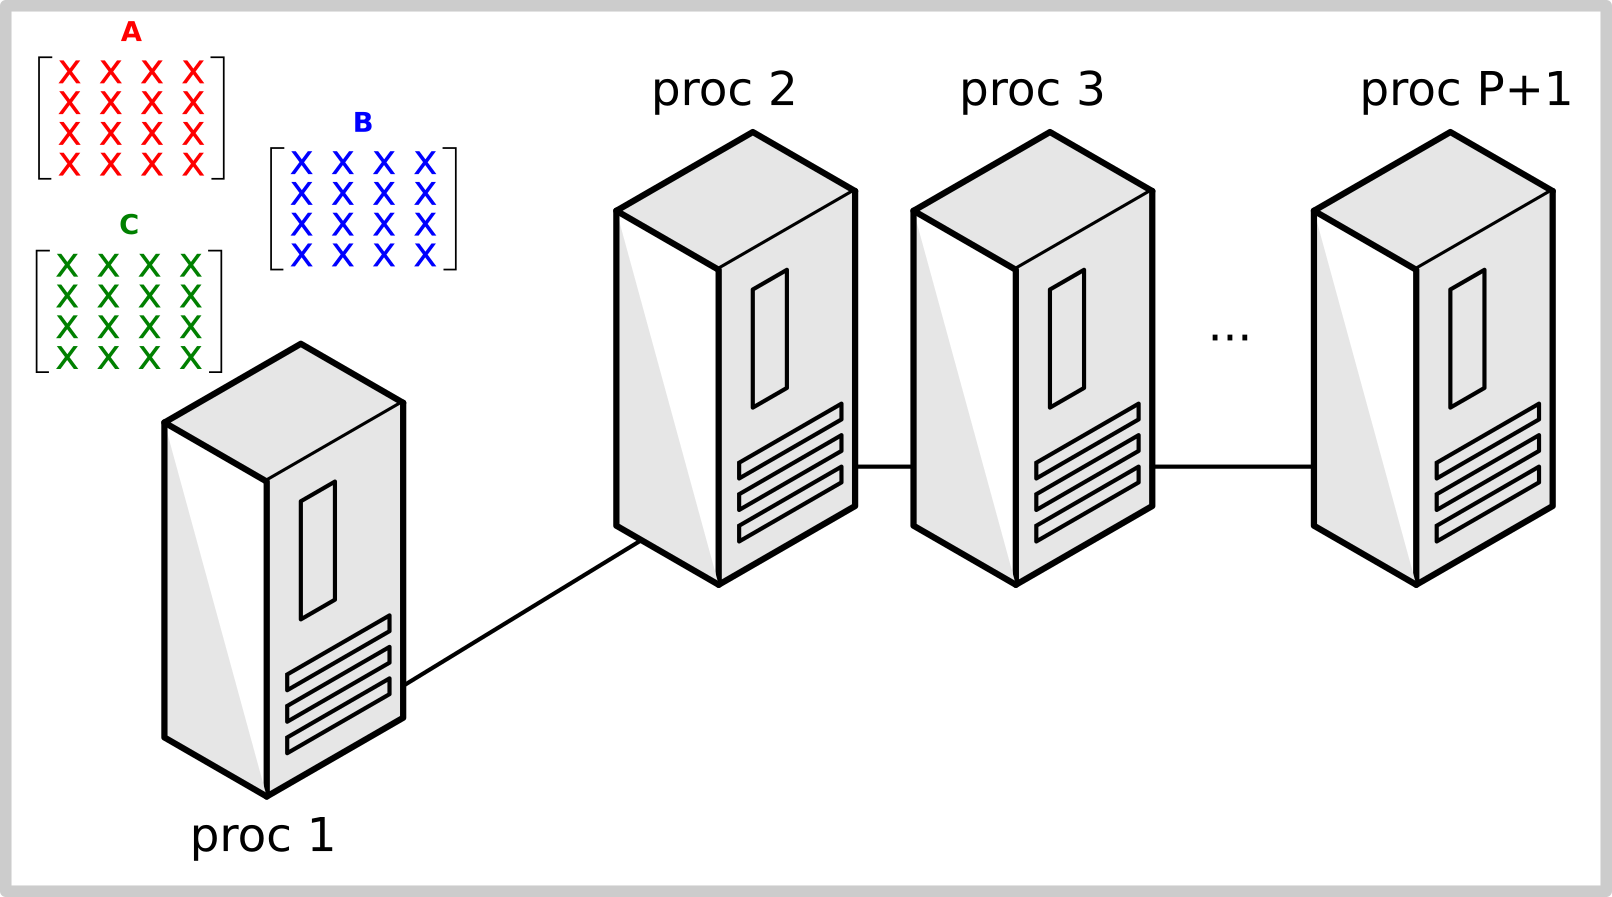
</div>


## Serial implementation

Consider the (naive) sequential algorithm:

In [ ]:
function matmul_seq!(C,A,B)
    m = size(A,1)
    n = size(A,2)
    l = size(B,2)
    z = zero(eltype(C))
    for j in 1:l
        for i in 1:m
            C[i,j] = z
            for k in 1:n
                @inbounds C[i,j] +=  A[i,k]*B[k,j]
            end
        end
    end
    C
end

<div class="alert alert-block alert-info">
<b>Note:</b> The matrix-matrix multiplication naively implemented with 3 nested loops as above is known to be very inefficient (memory bound). Libraries such as BLAS provide much more efficient implementations, which are the ones used in practice (e.g., by the `*` operator in Julia). We consider, our hand-written implementation as a simple way of expressing the algorithm we are interested in.
</div>

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the computational complexity of the sequential algorithm above when multiplying square matrices of size N by N ?    
</div>

    a) O(N)
    b) O(N^2)
    c) O(N^3)
    d) O(log(N)*N)

In [ ]:
# replace x with a, b, c, or, d;
# and run the cell to check you answer
answer = "c" 
alg_seq_check(answer)

<div class="alert alert-block alert-success">
<b>Question:</b>  The serial implementation above is written using three nested loops. Which are the ones that are trivially parallelizable? In other words, which are the loops that contain completely independent operations at each loop iteration and whose order can be changed without affecting the result?
</div>

    a) loop over k
    b) loops over i and k
    c) all loops
    d) loops over i and j

In [ ]:
answer = "d"
alg_seq_loops_check(answer)

## Parallel algorithms

We study three different parallel algorithms. For simplicity, we assume that matrices A, B, and C are N by N square matrices.


## Parallel algorithm 1

Each worker computes one entry of `C`. We need `P=N^2` workers.

 <div>
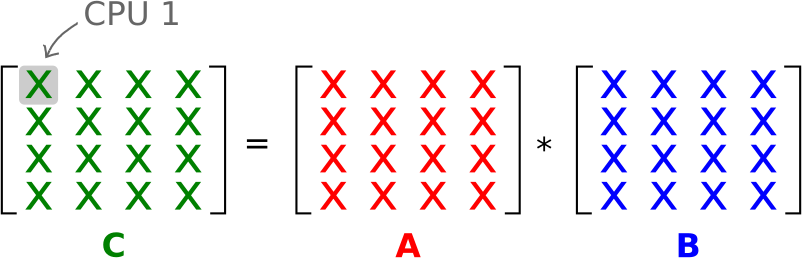
</div>

### Data dependencies

<div class="alert alert-block alert-success">
<b>Question:</b>  Which are the data dependencies of the computations done by the worker in charge of computing entry C[i,j] ?    
</div>

    a) column A[:,i] and row B[j,:]
    b) row A[i,:] and column B[:,j]
    c) the whole matrices A and B
    d) row A[i,:] and the whole matrix B

In [ ]:
answer = "x"
alg_1_deps_check(answer)

### Complexity

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the complexity of the communication and computations done by a worker?
</div>

    a) O(N) communication and O(N^2) computation
    b) O(N^2) communication and O(N) computation
    c) O(N^3) communication and O(N) computation
    d) O(N) communication and O(N) computation

In [ ]:
answer = "x"
alg_1_complex_check(answer)

### Parallel efficiency

The *speedup* represents how faster a parallel algorithm runs with respect to the serial one

$$\text{speedup} = \dfrac{\text{time serial algorithm}}{\text{time parallel algorithm}}$$

If we run an optimal parallel algorithm with P processes we expect it to run P times faster than the sequential implementation. I.e., the *optimal* speedup of a parallel algorithm on P processes is equal to P,

$$\text{optimal speedup} = P.$$

However, the *observed* speedup would be lower in practice. The closer the observed speedup is to the optimal one, the more efficient will be the parallel algorithm. To quantify how close (or how far) a parallel algorithm is from an optimal one, the parallel efficiency is defined:

$$\text{efficiency} = \dfrac{\text{speedup}}{\text{optimal speedup}} = \dfrac{\text{speedup}}{P}.$$


An optimal parallel algorithm will have efficiency equal to 1. A real parallel algorithm will usually have efficiency less than 1.



### Efficiency of algorithm 1

To determine the (theoretical) efficiency of algorithm 1, we need to estimate the time of the serial algorithm and the time of the parallel one. Remember that when we say that an algorithm has complexity O(X), this is equivalent to say that the cost (e.g. the time) of running the algorithm is proportional to X (for X large enough). In other words, the time of the algorithm can be written as C*X for a suitable constant C.

Using the computational complexities of the sequential and parallel algorithm 1 we can model the run times as follows

- The time of the sequential algorithm is Cm*N^3
- The time of the parallel algorithm in each worker is (Cn + Cw)*N

where

- Cn is a constant related the network throughput (the smaller Cn the faster the network).
- Cm and Cw are constants related with the FLOPS in the master and workers respectively (the smaller Cm and Cw the faster the computations).

<div class="alert alert-block alert-success">
<b>Question:</b> For which values of Cn, Cm, Cm the parallel algorithm 1 achieves the optimal efficiency? Assume that the time of the parallel algorithm is mainly the time spent in the workers. Since all the workers run in parallel, the time of the parallel algorithm can be approximated as the time in a worker.
</div>

    a) Cm == Cn + Cw
    b) Cm*N^2 == Cn + Cw
    c) Cm == (Cn + Cw)*N
    d) Cm == (Cn + Cw)*P


In [ ]:
answer = "x"
alg_1_time_check(answer)

## Implementation of algorithm 1

The following cells contain an implementation of the parallel algorihtm 1 using Julia's Distribtued module. Take a look and try to understand it.

In [ ]:
using Distributed

In [ ]:
if procs() == workers()
    addprocs(4)
end

In [ ]:
function matmul_dist_1!(C, A, B)
    m = size(A,1)
    n = size(A,2)
    l = size(B,2)
    z = zero(eltype(C))
    @assert nworkers() == m*n
    iw = 0    
    @sync for j in 1:l
        for i in 1:m
            Ai = A[i,:]
            Bj = B[:,j]
            iw += 1
            w = workers()[iw]
            ftr = @spawnat w begin
                Cij = z
                for k in 1:n
                    Cij += Ai[k]*Bj[k]
                end
                Cij
            end
            @async C[i,j] = fetch(ftr)
        end
    end
    C
    end

You can execute the following cells to test this implementation.

In [ ]:
using Test
N = 2
A = rand(N,N)
B = rand(N,N)
C = similar(A)
@test matmul_dist_1!(C,A,B) ≈ A*B

### A more practical version of algorithm 1

The implementation of algorithm 1 is very impractical. One needs as many processors as entries in the result matrix C. For 1000 times 1000 matrix one would need a supercomputer with one million processes! We can easily fix this problem by using less processors and spawning the computation of an entry in any of the available processes.
See the following code:

In [ ]:
function matmul_dist_1_v2!(C, A, B)
    m = size(A,1)
    n = size(A,2)
    l = size(B,2)
    z = zero(eltype(C))
    @sync for j in 1:l
        for i in 1:m
            Ai = A[i,:]
            Bj = B[:,j]
            # Note the :any
            ftr = @spawnat :any begin
                Cij = z
                for k in 1:n
                    Cij += Ai[k]*Bj[k]
                end
                Cij
            end
            @async C[i,j] = fetch(ftr)
        end
    end
    C
    end

With this new implementation, we can multiply matrices of arbitrary size with a fixed number of workers. Test it:

In [ ]:
using Test
N = 40
A = rand(N,N)
B = rand(N,N)
C = similar(A)
@test matmul_dist_1_v2!(C,A,B) ≈ A*B

Note that each worker will process on average N^2/P entries instead of a single one as in the original implementation. This invalidates our complexity analysis.

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the computational complexity of the work done in a worker for this variation of algorithm 1?
</div>

    a) O(N/P) communication and O(N^2) computation
    b) O(N^2) communication and O(N/P) computation
    c) O(N^3/P) communication and O(N^3/P) computation
    d) O(N/P) communication and O(N/P) computation

In [ ]:
answer = "x"
alg_1_v2_complex_check(answer)

<div class="alert alert-block alert-success">
<b>Question:</b> For which values of Cn, Cm, Cm the this variation of the parallel algorithm 1 achieves the optimal efficiency?
</div>

    a) Cm == Cn + Cw
    b) Cm*N^2 == Cn + Cw
    c) Cm == (Cn + Cw)*N
    d) Cm == (Cn + Cw)*P


In [ ]:
answer = "x"
alg_1_v2_time_check(answer)

## Parallel algorithm 2

Each worker computes a row of `C`. We need `P=N` workers.


<div>
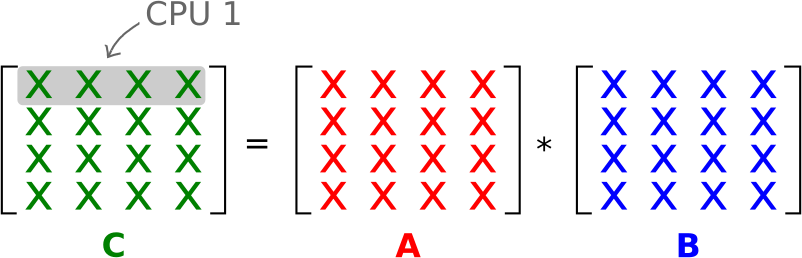
</div>

### Data dependencies

### Complexity

### Efficiency

### Implementation

In [ ]:
function matmul_dist_2!(C, A, B)
    m = size(A,1)
    n = size(A,2)
    l = size(B,2)
    z = zero(eltype(C))
    @assert nworkers() == m
    iw = 0
    @sync for i in 1:m
        Ai = A[i,:]
        iw += 1
        w = workers()[iw]
        ftr = @spawnat w begin
            Ci = fill(z,l)
            for j in 1:n
                for k in 1:n
                    Ci[j] += Ai[k]*B[k,j]
                end
            end
            Ci
        end
        @async C[i,:] = fetch(ftr)
    end
    C
    end

In [ ]:
using Test
N = 4
A = rand(N,N)
B = rand(N,N)
C = similar(A)
@test matmul_dist_2!(C,A,B) ≈ A*B

## Parallel algorithm 3

Each worker computes N/P consecutive rows of `C`.

<div>
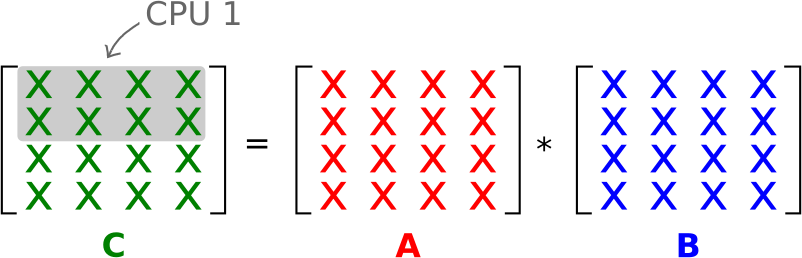
</div>

### Data dependencies

### Complexity

### Efficiency

### Implementation

The implementation of this algorithm is let as an exercise (see below). The following function is a helper to compute which subset of rows will be processed by a given worker.

In [ ]:
function local_rows(i,N)
    p = i
    P = nworkers()
    l = N ÷ P
    offset = l * (p-1)
    rem = N % P
    if rem >= (P-p+1)
        l = l + 1
        offset = offset + p - (P-rem) - 1
    end
    start = 1+offset
    stop = l+offset
    start:stop
end

Run the following cell to understand what function `local_rows` does.

In [ ]:
N = 12
for i in 1:nworkers()
    rows = local_rows(i,N)
    @show rows
end

Implement the parallel algorithm 3 in the function below. Test it with the provided test.

In [ ]:
function matmul_dist_3!(C, A, B)
    ## Implement your code here
    C
end

In [ ]:
using Test
N = 4
A = rand(N,N)
B = rand(N,N)
C = similar(A)
@test matmul_dist_3!(C,A,B) ≈ A*B

## Efficiency

The usual bottleneck in distributed computations is the overhead associated with the communication between processes.

As we can see, the distributed function is much slower than the handwritten serial version. The additional runtime is due to the communication between the master process and the worker processes. 
But how can we analyze the efficiency of this algorithm in general? In order to determine the efficiency, we have to compare how much computation time we can save to how much communication overhead there is in addition to the serial program. 

### Exercise 4
Determine the complexity of the serial algorithm and compare it with the complexity of the coordinator's work in the parallel algorithm. How much compute time does the coordinator save by offloading work to nodes? 

In [ ]:
a = "O(√N)"
b = "O(N)"
c = "O(N²)"
d = "O(N³)"

compute_time_serial = #TODO
compute_time_coordinator = #TODO
compute_time_saved = #TODO

@test (compute_time_serial, compute_time_coordinator, compute_time_saved) == solution_mm_par_04()

The complexity of the sequential algorithm is $O(N^3)$. The coordinator loops over the number of workers (= the number of elements in $C$, i.e. $N^2$). The computation of the dot-product is outsourced to the workers. So the complexity of the coordinator's work is $O(N^2)$. Thus, the coordinator saves $\frac{O(N^2)}{O(N^3)} = O(N)$ compute time.

### Exercise 5
How much communication overhead is there between the coordinator and the workers? In order to determine this, evaluate the size of the data that is passed between coordinator and workers.

In [ ]:
a = "O(log(N))"
b = "O(√N)"
c = "O(N)"
d = "O(N²)"

comm_overhead = #TODO
@test comm_overhead == solution_mm_par_05()

The coordinator sends 2 arrays of length `n` to each worker. After the worker is done computing, it sends 1 float back to the coordinator. So the complexity of the communication overhead is $O(2N +1) = O(N)$.
```julia
@async C[i,j] = @fetchfrom w dot(Ai, Bj)     # <------- Send 2 Arrays of length n to workers, Receive 1 number

```

In conclusion, we found out that the computation/communication ratio is $O(N)/O(N) = O(1)$, so algorithm 1 provides no gain in efficiency. 


# Parallel Algorithm 2
Another idea to parallelize the matrix multiplication is to let each processor compute one _row_ ($N$ elements) of $C$. This approach requires only $N$ workers. 

## Data Dependencies

Each worker requires the entire $B$ matrix and one row of $A$ as an input. Each processor can re-use the row of A $N$-times to compute the $N$-elements in its row. 
![Algorithm2](images/MM_par_algorithm_2.png)


The image below depicts the structure of Parallel Algorithm 2. 
The coordinator sends the $i$-th row of $A$ and the entire matrix B to worker node $i$. The worker nodes compute the whole row and send the result back to the coordinator.

![Structure of algorithm 2](images/MM_par_2_structure.png)


Let's first remove all unnecessary workers. 

In [ ]:
rmprocs(6:26)

In [ ]:
workers()

### Exercise 6
Provide the code for Parallel Algorithm 2. Test your algorithm using Julia's `@test` macro. You can view the solution to this exercise at the bottom of the notebook. 

In [ ]:
function matmul_dist2!(C, A, B)
    n = size(A,1)
    @assert size(A,2) == n
    @assert size(B,1) == n
    @assert size(B,2) == n
    @assert size(C,1) == n
    @assert size(C,2) == n
    @assert nworkers() == n
    
    # TODO: finish the code for algorithm 2
    
    C
end 

# TODO: test your code

## Efficiency

### Exercise 7
How efficient is Parallel Algorithm 2? Answer the following questions to determine the computation/communication ratio: 
1. How much compute time does the coordinator save by offloading work to nodes?
2. How much communication overhead is there between the coordinator and the workers?

In [ ]:
a = "O(1)"
b = "O(√N)"
c = "O(N)"
d = "O(N²)"
e = "O(N³)"

compute_time_saved = #TODO
comm_overhead = #TODO
comp_comm_ratio = #TODO

@test (compute_time_saved, comm_overhead, comp_comm_ratio) == solution_mm_par_07()

  1. The coordinator saves $O(N^2)$ computations. 
  2. The coordinator sends $N + N^2$ floats to each worker and receives $N$ floats from each worker. Thus, the communication overhead is $O(2N + N^2) = O(N^2)$. 
  
This results in a computation/communication ratio of $O(N^2)/O(N^2) = O(1)$. 

```julia

@async C[i,:] = @fetchfrom w Ai*B # <----- Worker does N² computations/ Send N + N² floats, receive N floats 
```

To conclude, our second algorithm is still inefficient. How can we design an algorithm that does more computation than communication? 

# Parallel Algorithm 3

Think of how to design an efficient algorithm to solve matrix multiplication in parallel. Hint: Assume that we are dealing with large problem sizes, thus $N >> P$ (where $P$ is the number of processors). 

If $N >> P$, we can assign _many rows_ to one processor. Each processor computes $N/P$ rows of $C$. 

## Data Dependencies

Each processor needs the entire $B$ matrix and $N/P$ rows of $A$. 

![Alg3DataDependencies](images/MM_par_algorithm_3.png)

Now let's start coding Algorithm 3. We'll use $P = 2$, so let's remove all other workers. 

In [ ]:
rmprocs(4:5)

In [ ]:
workers()

### Exercise 8
Write a function that calculates the row indices for each partition of matrix $A$. The function should store the result in the input variable `indices`, which is of the type `Array{Int64}[]` (a list of arrays). You can add arrays to this variable by calling `push!(indices, my_array)`. The $i$-th entry of `indices` should be an array of row indices of matrix $A$ for the $i$-th  worker. The function also receives the number of rows `n` and the number of processors `p` as input parameters. You can assume that `p` divides `n` without remainder, thus $n \pmod p = 0$.

In [ ]:
function calculate_partition!(indices, n, p)
    @assert mod(n,p) == 0
    # TODO: Calculate the row indices of matrix A for each worker. 
    # Store arrays of row indices in the variable indices.
    
end

In [ ]:
indices = Array{Int64}[]
n = 8
p = 2
calculate_partition!(indices, n, p)
@test indices == [[1,2,3,4], [5,6,7,8]]

### Exercise 9
Provide the code for Parallel Algorithm 3. Test your implementation using Julia macro `@test`. 

In [ ]:
function matmul_dist3!(C, A, B)
    n = size(A,1)
    p = nworkers()
    @assert size(A,2) == n
    @assert size(B,1) == n
    @assert size(B,2) == n
    @assert size(C,1) == n
    @assert size(C,2) == n
    @assert mod(n, p) == 0
    indices = Array{Int64}[]
    calculate_partition!(indices, n, p)
    @sync for (i, w) in enumerate(workers())
        # TODO: do matrix multiplication in parallel
    end
    C
end

# TODO: test your solution

## Efficiency again
Let's have a look at the efficiency of Parallel Algorithm 3. 

### Exercise 10
How efficient is this parallel algorithm? Determine the computation/communication ratio like in Exercise 7.  

In [ ]:
a = "O(1)"
b = "O(N/P)"
c = "O(N)"
d = "O(N²/P)"
e = "O(N²)"
f = "O(N³/P)"
g = "O(N³)"

compute_time_saved = #TODO
comm_overhead = #TODO
comp_comm_ratio = #TODO

@test (compute_time_saved, comm_overhead, comp_comm_ratio) == solution_mm_par_10()

- The workers now do $N/P \times N \times N$ computations, thus the complexity is $O(N³/P)$. 

- The coordinator sends the whole $B$ matrix ($N²$) and a part of the $A$ matrix ($N²/P$) and receives part of the $C$ matrix ($N²/P$). Hence, the complexity of the communication overhead is $O(N²/P)$. 
- Finally, we obtain a computation/communication ratio of $O(N³/P) / O(N²/P) = O(N/P)$. 


```julia

@async C[rows_w,:] = @fetchfrom w Aw*B # <----- Send N² + N²/P floats, get N²/P floats. Worker does N/P * N * N multiplications/additions. 
```

The table below compares the three parallel algorithms. 

<div id = "div1"></div>

| Algorithm | Parallelism <br>(#jobs) | Communication <br>per job | Computation <br>per job | Ratio computation/<br>communication |
|---|---|---|---|---|
| 1 | N² | 2N + 1 | N | O(1) |
| 2 | N | N + N² | N² | O(1) |
| 3 | P | N²/P + N² + N²/P | N³/P | O(N/P) |

In [ ]:
HTML("""
<style>
#div1 + table{
    font-size: 16px;
    border: 1px solid;
    width: 80%;
}

#div1 + table thead tr{
    background-color: #A5F1C2
}

#div1 + table tbody tr:nth-child(even){
    background-color: #CBF0D9
}

#div1 + table tbody tr:nth-child(odd){
    background-color: #E7EBE8
}
</style>""")


To conclude, only algorithm 3 provides an increase in efficiency, especially for large problem sizes. If $N >> P$, algorithm 3 will have a low communication overhead. 

## Scalability 
The matrices we have looked at in the previous examples were of a very small size. In the previous paragraph, we have established that the efficiency for Algorithm 3 is better especially for large matrices. Let's examine this by running the algorithm for different matrix sizes. First we will construct three matrices of different sizes. Next, we run the parallel algorithm for different numbers of processors. We evaluate the performance against the handwritten sequential version `matmul_hand!()` presented at the top of the notebook. We measure the performance by calculating the _speedup_, which is defined as 

$$
S_p = \frac{T_1}{T_p},
$$

where $T_1$ denotes the runtimes of the sequential algorithm on one node, $T_p$ denotes the runtime of the parallel algorithm on $p$ nodes. The ideal speedup is $S_p = p$. We will look more into speedups and how to measure efficiency in a later section of this course. NB: the following cells take about 6 - 10 minutes of compute time. 

In [ ]:
matrix_sizes = [84, 420, 2100]

function initialize_matrices!(array_A, array_B, array_C)
   for n in matrix_sizes
        A = rand(n, n)
        B = rand(n, n)
        C = rand(n, n)
        push!(array_A, A)
        push!(array_B, B)
        push!(array_C, C)
    end
end

matrices_A = Matrix{Float64}[]
matrices_B = Matrix{Float64}[]
matrices_C = Matrix{Float64}[]

initialize_matrices!(matrices_A, matrices_B, matrices_C)

In [ ]:
n_workers = [0, 1, 2, 4, 7]
rmprocs(workers())
runtimes = zeros(length(n_workers), length(matrix_sizes));

    
for (i,p) in enumerate(n_workers)
    # Add sufficient worker processes
    if p >= 1
        addprocs(p)
    end
    for (j,n) in enumerate(matrix_sizes)
        @show p, n
        C = matrices_C[j]
        A = matrices_A[j]
        B = matrices_B[j]
        if nprocs() == 1
        # Run sequential algorithm if 0 workers
            runtimes[i,j] = @belapsed matmul_hand!(C, A, B)
        else
            runtimes[i,j] = @belapsed matmul_dist3!(C, A, B)
        end
        @show runtimes[i,j]
    end
end

In [ ]:
# Plot runtimes 
using Plots

function calculate_speedups!(speedup, runtimes, reference)
    @assert length(reference) == size(runtimes,2)
    @assert size(speedup,1) == size(runtimes,1)
    @assert size(speedup,2) == size(runtimes,2)
    for j in 1:size(runtimes,2)
        for i in 1:size(runtimes,1)
            Sₚ = reference[j] / runtimes[i,j] 
            speedup[i,j] = Sₚ
        end
    end
end

speedups = zeros(length(n_workers)-1, length(matrix_sizes))
reference = runtimes[1,:]
calculate_speedups!(speedups, runtimes[2:end, :], reference)

plot(n_workers[2:end], 
    [speedups[:,1], speedups[:,2], speedups[:,3]], 
    label=["N=$(matrix_sizes[1])" "N=$(matrix_sizes[2])" "N=$(matrix_sizes[3])"],
    xlabel="# workers", ylabel="speedup",
    title="Speedups compared with sequential version matmul_hand!")


As we can see, the speedups are higher for larger matrix sizes. We can also observe that the speedups decrease when using more processors. The speedups are superlinear, that is, much larger than the theoretical ideal speedup. The reason for this is that we compare to a very slow handwritten solution whilst using the optimized Julia built-in function ` * ` on the workers in the parallel computation. If we were to compare the performance with Julia's `A * B`, we would see that the parallel algorithm performs worse even for large matrix sizes, since this function is highly optimized. We will get more into the efficiency analysis of parallel algorithms later in the course.

# Discussion
The first problem we have looked at, Matrix Multiplication, can be parallelized by sending parts of the input matrices to each worker and collecting the result at the end. This problem is **trivial to parallelize**, since the workers can do their computations independently from one another. In the following sections, we will look at other algorithms which require intermediate communication.  

Another key insight is that we can attain a better performance by chosing a **large grain size**, thus by dividing the matrix $A$ into larger chunks of data.

Finally, the time saved by doing more computation than communication is increased in **large problem sizes**. 


# Solution to Exercises
### Solution to Exercise 3

The following cell shows the code for the first parallel algorithm with the correct macros.

In [ ]:
@everywhere using LinearAlgebra 

function matmul_dist1!(C, A, B)
    n = size(A,1)
    @assert size(A,2) == n
    @assert size(B,1) == n
    @assert size(B,2) == n
    @assert size(C,1) == n
    @assert size(C,2) == n
    @assert nworkers() == n^2 
    # Let each worker compute one element 
    @sync for w in workers()
        # Compute row and column index from worker id
        i, j = index_from_wid(w)
        Ai = A[i,:]
        Bj = B[:,j]
        # Do element computation in parallel
        @async C[i,j] = @fetchfrom w dot(Ai, Bj)
    end
    C
end

### Solution to Exercise 6
The cell below contains the code for parallel algorithm 2.

In [ ]:
function matmul_dist2!(C, A, B)
    n = size(A,1)
    @assert size(A,2) == n
    @assert size(B,1) == n
    @assert size(B,2) == n
    @assert size(C,1) == n
    @assert size(C,2) == n
    @assert nworkers() == n
    # Let each worker compute one row 
    @sync for w in workers()
        # Compute row index from worker id 
        i = w - 1
        # Make sure Ai is an array, not a vector
        Ai = A[[i],:]
        # Do row computation in parallel
        @async C[i,:] = @fetchfrom w Ai*B
    end
    C
end

# Test solution
C1 = matmul_dist2!(C, A, B)
@test C1 ≈ A * B

### Solution to Exercise 8

In [ ]:
function calculate_partition!(indices, n, p)
    @assert mod(n,p) == 0
    nrows = div(n,p)
    for i in 1:p
        range =((i-1) * nrows + 1) : (i*nrows)
        push!(indices, range)
    end
end
    

### Solution to Exercise 9
The following cell contains the code for parallel algorithm 3.

In [ ]:
function matmul_dist3!(C, A, B)
    n = size(A,1)
    p = nworkers()
    @assert size(A,2) == n
    @assert size(B,1) == n
    @assert size(B,2) == n
    @assert size(C,1) == n
    @assert size(C,2) == n
    @assert mod(n, p) == 0
    indices = Array{Int64}[]
    calculate_partition!(indices, n, p)
    @sync for (i, w) in enumerate(workers())
        # Get row indices of this partition
        rows_w = indices[i]
        Aw = A[rows_w,:]
        # Do partition computation in parallel
        @async C[rows_w,:] = @fetchfrom w Aw*B
    end
    C
end

# Test solution
C1 = matmul_dist3!(C, A, B)
@test C1 ≈ A * B

## Solutions

In [ ]:
function matmul_dist_1!(C, A, B)
    m = size(A,1)
    n = size(A,2)
    l = size(B,2)
    @assert size(B,1) == n
    @assert size(C,1) == m
    @assert size(C,2) == l
    @sync for j in 1:l # Note the @sync!
        for i in 1:m
            Ai = A[i,:]
            Bj = B[:,j]
            # Compute this entry in any of the available workers 
            @async C[i,j] = fetch(@spawnat :any dot(Ai, Bj))
        end
    end
    C
end